In [2]:
import nltk
import numpy as np
import pickle
import pandas as pd
import json

In [ ]:
## must download vader_lexicon for vader sentiment algorithm
nltk.download_shell()

## Data Loading

Load clean, processed data

In [12]:
df = pd.read_pickle("df")

In [13]:
## array of strings, 1 x n 
descriptions = df["description"].tolist()

## array of ints, 1 x n
prices = df["price"].tolist()

## Sentiment Analysis

Sentiment analysis algorithms. Each takes a single string as input.

In [ ]:
def createDict():
    sentiment_dictionary = {}
    for line in open('afinn_dict.txt'):
        word,score = line.split('\t')
        sentiment_dictionary[word] = int(score)
    return sentiment_dictionary
sentiment_dictionary = createDict()

def sentimentAfinn(sentence):
    '''
    AFINN is a dictionary of polarity scores [-5,5] by word.
    This algorithm sums the scores for each word in the sentence, then
    classifies the entire sentence based on the sum's sign.
    '''
    sentence_tokens = sentence.split(' ')
    score = 0
    for token in sentence_tokens:
        score += sentiment_dictionary.get(token,0)
    ## if we want raw integer, not scaled
    return score
    ## if we want it to be scaled between -1 and 1
    # return np.sign(score)

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentim_int_analyzer = SentimentIntensityAnalyzer()
def sentimentVader(sentence):    
    '''
    Sentiment object contains { 'pos', 'neg', 'neu', 'compound' } where pos+neg+neu=1, compound is [-1,1].
    This algorithm returns the 'pos', 'neu', 'neg' values
    '''
    ss = sentim_int_analyzer.polarity_scores(sentence)
    return [ss['pos'], ss['neu'], ss['neg']]

In [ ]:
# delete later
sentimentAfinn("This wine is so bad it made me vomit.")

In [ ]:
# delete later
sentimentVader("This wine is so bad it made me vomit.")

Create sentiment feature vector.

In [ ]:
sentiments_afinn = list(map(sentimentAfinn,descriptions))

In [ ]:
sentiments_vader = list(map(sentimentVader,descriptions))

In [ ]:
# delete later
print(sentiments_afinn[0:8])
print(len(sentiments_afinn))

In [ ]:
# delete later
print(sentiments_vader[0:8])
print(len(sentiments_vader))

Saving the transformed feature vectors to file.

In [ ]:
with open('sentiment_sums.json', 'w') as outfile:
    json.dump(sentiments_afinn, outfile)

In [ ]:
with open('sentiment_probabilities.json', 'w') as outfile:
    json.dump(sentiments_vader, outfile)

Graphical analysis.

In [15]:
import matplotlib.pyplot as plt

In [3]:
with open('sentiment_sums.json') as json_data:
    sentiment_sums = json.load(json_data)

In [8]:
with open('sentiment_probabilities.json') as json_data:
    sentiment_probs = json.load(json_data)

In [31]:
sentiment_probs = np.matrix(sentiment_probs)

In [14]:
prices = df["price"].tolist()
points = df["points"].tolist()

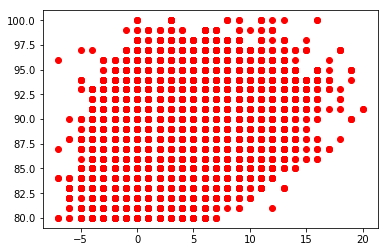

In [44]:
# plotting sentiment sums against points
plt.plot(sentiment_sums, points, 'ro')
plt.show()

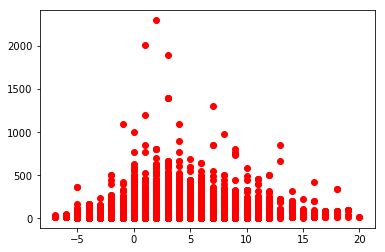

In [47]:
# plotting sentiment sums against prices
plt.plot(sentiment_sums, prices, 'ro')
plt.show()

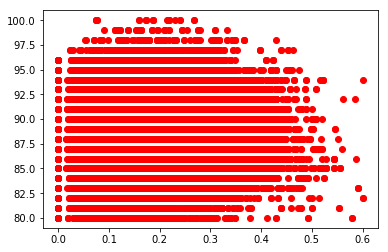

In [50]:
# plotting positive probabilities against points
plt.plot(sentiment_probs[:,0], points, 'ro')
plt.show()

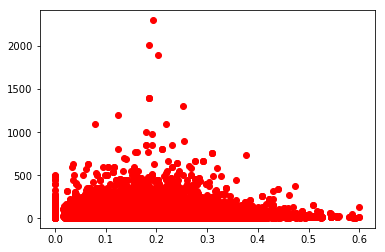

In [51]:
# plotting positive probabilities against price
plt.plot(sentiment_probs[:,0], prices, 'ro')
plt.show()

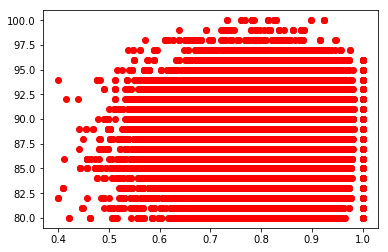

In [52]:
# plotting neutral probabilities against points
plt.plot(sentiment_probs[:,1], points, 'ro')
plt.show()

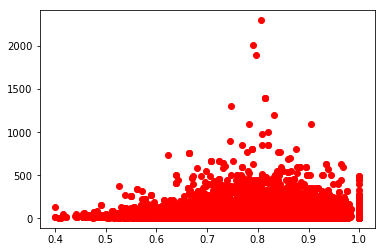

In [53]:
# plotting neutral probabilities against prices
plt.plot(sentiment_probs[:,1], prices, 'ro')
plt.show()

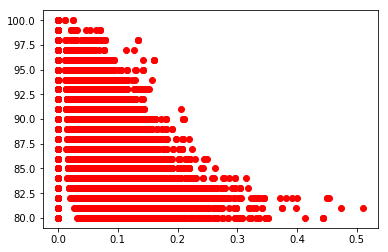

In [54]:
# plotting negative probabilities against points
plt.plot(sentiment_probs[:,2], points, 'ro')
plt.show()

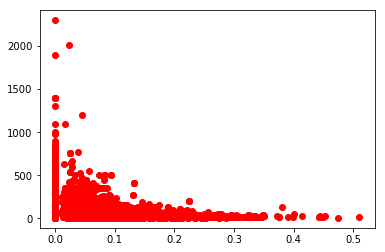

In [55]:
# plotting negative probabilities against price
plt.plot(sentiment_probs[:,2], prices, 'ro')
plt.show()

## Neural Network